## Initial Setup

In [22]:
# Initial setup...
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import fitsio
from scipy import interpolate
import glob
import math
import os
import sys
import os.path
from pathlib import Path
import h5py
import bisect
from astropy.cosmology import FlatLambdaCDM
import argparse
import os.path
from os import path
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io.fits.verify import VerifyWarning
import warnings
warnings.simplefilter('ignore', category=VerifyWarning)

c = 2.99e10   # speed of light in cm/sec...

# v. 2.6.1 (which works with python 2.7) installed from 
#  https://imageio.readthedocs.io/en/stable/installation.html


home = '~/'
home = os.path.expanduser(home)


## Here we read the csv file that contains the matched data for the 20 kilonova models.
From that we get the list of redshifts for the fake kilonovae. 
Then we read in the names of the Kasen models we chose to use.
We also specify where the output will be placed, where SEDs will be placed and the png files. 

In [23]:
galaxies = pd.read_csv('DP0/input/truth_DP0_phosim_real.csv')

redshift = galaxies['redshift'] #DC2 photo-z

kasener = pd.read_csv('~/KDC/kasen/kasen.choice')

kasen =  kasener['kasen_model']

output_dirname = home+'KDC/kasen'
sed_dirname = home+'KDC/kasen/SEDs/obj4'
png_dirname = home+'KDC/kasen/PNGs'
kasen_dir =home+'Kasen_Kilonova_Models_2017/systematic_kilonova_model_grid'
kasen2_check = False
debug=False
verbose = 0


## Synthetic Photometry Methods

Based on /data/des40.a/data/dtucker/Y6A1_abscal/calc_abmag.py, which itself made use of some variations of code developed by Keith Bechtol and Eli Rykoff for DES Y3 interstellar reddening corrections...


In [24]:
# Create an argparse Namespace and run "calc_abmag(args)"...
#  (e.g., run_calc_abmag('u,g,r,i,z,Y', bandpassFile, tempFile, 'LAMBDA', 'Flam', 'Flam', verbose) )

def run_calc_abmag(bandList, bandpassFile, spectrumFile, colname_wave, colname_flam, flux_type, verbose):
    
    args = argparse.Namespace(bandList = bandList, 
                              bandpassFile = bandpassFile, 
                              spectrumFile = spectrumFile, 
                              colname_wave = colname_wave, 
                              colname_flam = colname_flam, 
                              flux_type = flux_type, 
                              verbose = verbose)
    
    if args.verbose > 0: print(args)

    status = calc_abmag(args)
    
     
    return status

    
    
#parser.add_argument('--bandList', help='comma-separated list with no spaces', default='g,r,i,z,Y')
#parser.add_argument('--bandpassFile', help='name of the input plan file', default='DES_STD_BANDPASSES_Y3A2_ugrizY.test.csv')
#parser.add_argument('--spectrumFile', help='name of the input plan file (can be CSV file or a synphot-style FITS file')
#parser.add_argument('--colname_wave', help='name of the wavelength column (in case of a CSV spectrumFile)', default='wave')
#parser.add_argument('--colname_flux', help='name of the flux column (in case of a CSV spectrumFile)', default='flux')
#parser.add_argument('--flux_type', help='type of flux (Flam [ergs/sec/cm**2/Angstrom] or Fnu [ergs/sec/cm**2/Hz])? ', default='Flam')
#parser.add_argument('--verbose', help='verbosity level of output to screen (0,1,2,...)', default=0, type=int)
    

In [25]:
# Main method for calculating synthetic AB magnitudes...

def calc_abmag(args):

    #  Extract the bandList...
    bandList = args.bandList
    bandList = bandList.split(',')
    if args.verbose > 0:
        print('bandList: ', bandList)

    #  Extract the name of the bandpassFile...
    bandpassFile = args.bandpassFile
    if os.path.isfile(bandpassFile)==False:
        print("""bandpassFile %s does not exist...""" % (bandpassFile))
        print('Returning with error code 1 now...')
        return 1
    if args.verbose > 0:
        print('bandpassFile: ', bandpassFile)

    #  Extract the name of the spectrum file...
    spectrumFile = args.spectrumFile
    if os.path.isfile(spectrumFile)==False:
        print("""spectrumFile %s does not exist...""" % (spectrumFile))
        print('Returning with error code 1 now...')
        return 1
    if args.verbose > 0:
        print('spectrumFile: ', spectrumFile)

    # Try to determine spectrumFile type (FITS file or CSV file)...
    spectrumType = 'Unknown'
    try:
        hdulist = fits.open(spectrumFile)
        hdulist.close()
        spectrumType = 'FITS'
    except IOError:
        if args.verbose > 2:
            print("""spectrumFile %s is not a FITS file...""" % (spectrumFile))
        try:
            df_test = pd.read_csv(spectrumFile)
            spectrumType = 'CSV'
        except IOError:
            if args.verbose > 2:
                print("""spectrumFile %s is not a CSV file...""" % (spectrumFile))

    # Read in spectrumFile and create a SciPy interpolated function of the spectrum...
    if spectrumType == 'FITS':
        flux,wave_lo,wave_hi = getSpectrumSynphot(spectrumFile, fluxFactor=1.0)
    elif spectrumType == 'CSV':
        flux,wave_lo,wave_hi = getSpectrumCSV(spectrumFile, 
                                              colname_wave=args.colname_wave, colname_flam=args.colname_flam, 
                                              fluxFactor=1.0)
    else:
        print("""Spectrum file %s is of unknown type...""" % (spectrumFile))
        print('Returning with error code 1 now...')
        return 1

    # Read the bandpassFile into a Pandas DataFrame...
    df_resp = pd.read_csv(bandpassFile, comment='#')

    # Check to make sure the spectrumFile covers at least the same wavelength range
    #  as the bandpassFile...
    if ( (wave_lo > df_resp['LAMBDA'].min()) or (wave_hi < df_resp['LAMBDA'].max()) ):
        print("""WARNING:  %s does not cover the full wavelength range of %s""" % (spectrumFile, bandpassFile))
        print('Returning with error code 1 now...')
        return 1

    # Create wavelength_array and flux_array...
    delta_wavelength = 1.0 # angstroms
    wavelength_array = np.arange(wave_lo, wave_hi, delta_wavelength)
    flux_array = flux(wavelength_array)
    

    # If needed, convert flux from flam to fnu...
    if args.flux_type == 'Fnu':
        fnu_array = flux_array
    elif args.flux_type == 'Flam':
        c_kms = 299792.5        # speed of light in km/s
        c_ms = 1000.*c_kms      # speed of light in m/s
        c_as = (1.000e10)*c_ms  # speed of light in Angstroms/sec
        fnu_array = flux_array * wavelength_array * wavelength_array / c_as
    else:
        print("""Flux type %s is unknown...""" % (args.flux_type))
        print('Returning with error code 1 now...')
        return 1


    # Print out header...
    outputLine = ''
    for band in bandList:
        outputLine =  """%s,%s""" % (outputLine, band)
  #  print(outputLine[1:])

    outputLine = ''
    for band in bandList:

        response = interpolate.interp1d(df_resp['LAMBDA'], df_resp[band],
                                        bounds_error=False, fill_value=0.,
                                        kind='linear')
        response_array = response(wavelength_array)

        try:
            abmag = calc_abmag_value(wavelength_array, response_array, fnu_array)
        except Exception:
            abmag = -9999.

        outputLine =  """%s,%.4f""" % (outputLine, abmag)

   # print(outputLine[1:])
    f.write(str(outputLine[1:])+","+"{:.2f}".format(t_kn)+"\n")
    return 0

In [26]:
# Calculate abmag using the wavelength version of the Fukugita et al. (1996) equation...

def calc_abmag_value(wavelength_array, response_array, fnu_array):

    # Calculate the abmag...
    numerator = np.sum(fnu_array * response_array / wavelength_array)
    denominator = np.sum(response_array / wavelength_array)
    abmag_value = -2.5*math.log10(numerator/denominator) - 48.60

    return abmag_value

In [27]:
# Return a SciPy interpolation function of a Synphot-style FITS spectrum...
#  (Based on code from Keith Bechtol's synthesize_locus.py.)
# Unless otherwise noted, fluxes are assumed to be Flam and wavelengths
#  are assumed to be in Angstroms...

def getSpectrumSynphot(synphotFileName, fluxFactor=1.0):

    try:

        hdulist = fits.open(synphotFileName)
        t = Table.read(hdulist[1])
        hdulist.close()

    except IOError:

        print("""Could not read %s""" % synphotFileName)
        sys.exit(1)


    wave = t['WAVELENGTH'].data.tolist()
    wave_lo = min(wave)
    wave_hi = max(wave)
    t['FLUX'] = fluxFactor*t['FLUX']
    flam = t['FLUX'].data.tolist()
    flam = t['FLUX'].data.tolist()
    data = {'wavelength': wave, 'flux': flam}

    f = interpolate.interp1d(data['wavelength'], data['flux'],
                             bounds_error=True,
                             kind='linear')

    return f,wave_lo,wave_hi

In [28]:
# Return a SciPy interpolation function of a CSV-style spectrum...
#  (Based on code from Keith Bechtol's synthesize_locus.py.)
# Unless otherwise noted, fluxes are assumed to be Flam and wavelengths
#  are assumed to be in Angstroms...

def getSpectrumCSV(csvFileName, colname_wave='wave', colname_flam='flux', fluxFactor=1.0):

    try:

        df = pd.read_csv(csvFileName)

    except IOError:

        print("""Could not read %s""" % csvFileName)
        sys.exit(1)


    columnNameList = df.columns.tolist()

    if colname_wave not in columnNameList:
        print("""Column %s not in %s""" % (colname_wave, csvFileName))
        sys.exit(1)

    if colname_flam not in columnNameList:
        print("""Column %s not in %s""" % (colname_wave, csvFileName))
        sys.exit(1)

    wave = df[colname_wave].tolist()
    wave_lo = min(wave)
    wave_hi = max(wave)
    df[colname_flam] = fluxFactor*df[colname_flam]
    flam = df[colname_flam].tolist()
    data = {'wavelength': wave, 'flux': flam}

    f = interpolate.interp1d(data['wavelength'], data['flux'],
                             bounds_error=True,
                             kind='linear')

    return f,wave_lo,wave_hi

## Setting up the cosmology

In [29]:
# Redshift to luminosity distance...
#  Default values of H0 and Omega0 are from Bennett et al. (2014)...
def zToDlum(z, H0=69.6, Om0=0.286):
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    # comoving distance...
    Dcom = cosmo.comoving_distance(z)
    # luminosity distance...
    Dlum = (1.+z)*Dcom
    return Dlum


# Mpc_to_cm...
def Mpc_to_cm(Dmpc):
    Dcm = Dmpc*1.00e6*3.086e+18
    return Dcm

## Read in bandpass file

In [30]:
bandpassFile = home+'KDC/notebooks/input/LSST.dat'

# Comma-separated list with no spaces of passbands to be used...
bandList = ['u','g','r','i','z','Y']

# bandpass color palette:
bandpassColors_dict = {'u':'#56b4e9',
                       'g':'#008060',
                       'r':'#ff4000',
                       'i':'#850000',
                       'z':'#6600cc',
                       'y':'#000000',
                       'Y':'#000000'
                      }
    
df_band = pd.read_csv(bandpassFile, comment='#')

## Read in and Plot Kilonova SED...

In [34]:
#This turns on plotting if set equal to True
plotter = False
kasen2_check = False

for i in range(0,len(kasen)):
    z_kn = redshift[i]
    kasen1 = kasen_dir+'/'+kasen[i]
    
    Dlum = zToDlum(z_kn)
    Dlum_cm = Mpc_to_cm(Dlum)

    #This is the output light curve file
    myfile = Path("output/light_curve_"+str(i)+".txt")
    #This is the output file that contains the time after GW event
    #myfile2 = Path("output/time.txt")

    #I did this so i
    if myfile.exists():
        !rm output/light_curve_"+str(i)+".txt"
    #if myfile2.exists():
    #    !rm output/time.txt

   # f = open("output/light_curve"+str(i)+".txt", "w")
   # f.write('Ks,time\n')
    f = open(myfile, "w")
    f.write('u,g,r,i,z,y,time\n')
    #f2 = open("output/time.txt", "w")
    #f2.write("day_after \n")

# open Kasen model file
#fin    = h5py.File(kasen_pathname,'r')

#RED FILE
# open model file
    fin    = h5py.File(kasen1,'r')
# frequency in Hz
    nu    = np.array(fin['nu'],dtype='d')
# array of time in seconds
    times = np.array(fin['time'])
# convert time to days
    times = times/3600.0/24.0

    fine = np.where((times > 0.00) & (times < 9.05))
    timer = times[fine]

# specific luminosity (ergs/s/Hz)
# this is a 2D array, Lnu[times][nu]
    Lnu_all   = np.array(fin['Lnu'],dtype='d')
#_____________________________________________
#I put this trigger here so if there is only 1 Kasen model, it still runs

    if kasen2_check == True:
#BLUE FILE
# open model file
        fin2    = h5py.File(kasen2,'r')

    # frequency in Hz
        nu2    = np.array(fin2['nu'],dtype='d')
    # array of time in seconds
        times2 = np.array(fin2['time'])
    # convert time to days
        times2 = times2/3600.0/24.0

    # specific luminosity (ergs/s/Hz)
    # this is a 2D array, Lnu[times][nu]
        Lnu_all2   = np.array(fin2['Lnu'],dtype='d')

    


    for t_kn in timer:
 #   if t_kn < 0.00: continue
    
        if debug == True:  t_kn = 4.0
        
   # print('working on ',"{:.2f}".format(t_kn))
  #  f2.write(str(t_kn)+" \n")
    
        try:
        # index corresponding to t_kn
            it = bisect.bisect(times,t_kn)
        # spectrum at this epoch
            Lnu = Lnu_all[it,:]
    #    Lnu2 = Lnu_all2[it,:]
        except:
            print("Index out of bounds?")
            continue
    
    # Convert to in Llam (ergs/s/Angstrom)...
        lam0  = c/nu*1e8          # rest-frame wavelength
        lam   = lam0*(1+z_kn)     # redshifted wavelength
        Llam = Lnu*nu**2.0/c/1e8  # Llam
       
    #Makes a dataframe of rest-frame wavelength, redshifted wavelength and flux
    
        df_model_red = pd.DataFrame({'LAMBDA0':lam0, 'LAMBDA':lam, 'Llam':Llam})
    
    #This is where we add the second model and combine it with the first, if there is a second model.
        if (kasen2_check == True): # and (t_kn < 2.05):
            print('working on ',"{:.2f}".format(t_kn), ' with blue and red models')
        # Convert to in Llam (ergs/s/Angstrom)...
            lam02  = c/nu2*1e8      # rest-frame wavelength
            lam2   = lam02*(1+z_kn) # redshifted wavelength
            Llam2 = Lnu2*nu2**2.0/c/1e8  # Llam
          
            df_model_blue = pd.DataFrame({'LAMBDA0':lam02, 'LAMBDA':lam2, 'Llam':Llam2})
    
            df_model_comb = df_model_blue.copy()

            df_model_comb['Llam'] =  df_model_blue['Llam'] + df_model_red['Llam'] 

            df_model_combined = pd.DataFrame({"LAMBDA":df_model_red['LAMBDA'], "Llam":df_model_comb['Llam']})
        else:
            df_model_combined = df_model_red
            print('working on ',"{:.2f}".format(t_kn), 'for system '+str(i)+' of '+str(len(kasen))+' with red model only')
    
 #   bothfile = """test/both_"""+str(t_kn)
 #   redfile = """test/red_"""+str(t_kn)
 #   bluefile = """test/blue_"""+str(t_kn)
 #   df_model_combined.to_csv(bothfile)
 #   df_model_red.to_csv(redfile)
 #   df_model_blue.to_csv(bluefile)
    
   # df_model_combined.plot('LAMBDA','Llam', color='blue', xlim=[3000.,10000.], title=str(t_kn))
   # plt.show()
        
  #  plt.annotate('t = '+str(t_kn)+' day', (28000, this), horizontalalignment='right', fontsize=22)
    
    #print min(lam), max(lam)
        wavelength_array = np.arange(min(lam0), max(lam0), 1.0)
    
        spec_flux_model = interpolate.interp1d(df_model_combined.LAMBDA, df_model_combined.Llam,bounds_error=False, fill_value=0.,kind='linear')
        spec_flux_model_array = spec_flux_model(wavelength_array)

        df_model_new = pd.DataFrame({'LAMBDA':wavelength_array, 'Llam':spec_flux_model_array})

    #norm = df_model_new['Llam'].median()
        norm = df_model_new[( (df_model_new.LAMBDA > 3000.) & (df_model_new.LAMBDA < 12000.) )].Llam.max()

        df_model_new['normLlam'] = df_model_new['Llam'] / norm

 #   spec_flux_model = interpolate.interp1d(df_model.LAMBDA0, df_model.Llam,bounds_error=False, fill_value=0.,kind='linear')
 #   spec_flux_model_array = spec_flux_model(wavelength_array)

 #   df_model_new = pd.DataFrame({'LAMBDA':wavelength_array, 'Llam':spec_flux_model_array})

    #norm = df_model_new['Llam'].median()
 #   norm = df_model_new[( (df_model_new.LAMBDA > 0.) & (df_model_new.LAMBDA < 12000.) )].Llam.max()
 #   df_model_new['normLlam'] = df_model_new['Llam']/norm

    #ax = df_model_new.plot('LAMBDA','normLlam', c='#000000', label='Model', fontsize=18)
 #   ax = df_model_new.plot('LAMBDA','normLlam', c='#888888', label='Model')
        # Distance to KN in cm...

#HERE IS WHERE WE PRINT THE SEDs
        flux_array = spec_flux_model_array / ((4.*np.pi*(Dlum_cm)**2.))#*(1E-17)) #Flam [ergs/s/cm2/Angstrom]
        nm_array = wavelength_array / 10.
    
        df_model_final = pd.DataFrame({'LAMBDA':nm_array, 'Flam':flux_array})
        outputFile1 = 'sed_'+"{:.2f}".format(z_kn)+"_"+"{:.2f}".format(t_kn)+'.spec'
        outputFile1 = os.path.join(sed_dirname, outputFile1)
  # print(outputFile1)
  # print(df_model_new['LAMBDA'])
        df_model_final.to_csv(outputFile1,mode='w', index = False, sep=' ')

#THIS PART MAKES PLOTS.
#Plots are of the filter bandpasses and the kasen spectrum.
#It also plots the different parts of the Kasen model. 
#You can turn it on by setting plotter = True at the beginning.
        if plotter == True:
            ax = df_model_new.plot('LAMBDA','normLlam', c='#888888', label='Model')    
            for band in bandList:
            #print band
                df_band.plot('LAMBDA', band, c=bandpassColors_dict[band], ax=ax)

            title = """%s""" % (fblue)
            plt.title(title, fontsize=16)
            plt.xlim([3000., 11000.])
        #plt.ylim([0.,1.1])
        #ax.legend(loc='upper right', fontsize=14, framealpha=0.5)
        #plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            ax.set_xlabel('wavelength (observed frame) [$\\AA$]',fontsize=16)
            ax.set_ylabel('Relative $F_{\lambda}$',fontsize=16)
            ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
        #textstr = """$z$=%.3f\n$t$=%.2f days""" % (z_kn, t_kn)
      #  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        #ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
            ax.grid(False)
            plt.show()
        
            ax2 = df_model_blue.plot('LAMBDA','Llam', color='blue', label='light r-process component',xlim=[3000.,30000.])
       # df_model_blue.plot('LAMBDA', 'Llam', ax=ax, xlim=[3000.,30000.], label='light r-process component')
            df_model_red.plot('LAMBDA', 'Llam', color='red', ax=ax2, label='heavy r-process component')
            df_model_comb.plot('LAMBDA', 'Llam', color='black', ax=ax2, label = 'composite')
            plt.show()
        #outputFile = """KNspectrum.%s_z%.3f_a%05.2f.png""" % (fblue, z_kn, t_kn)
            outputFile = """KNspectrum._z%.3f_a%05.2f.png""" % (z_kn, t_kn)
        #outputFile = 'KNspectrum.z'+str(z_kn)+'_'+str(t_kn)+'.png'
            outputFile = os.path.join(png_dirname, outputFile)
    
            plt.tight_layout()
            plt.savefig(outputFile)



    # Calculate Flam [ergs/s/cm**2/Angstrom] from Llam [ergs/s/Angstrom] and Dlum_cm [cm]...
    #Flam is flux and Llam is luminosity.
        df_model_new['Flam'] = df_model_new['Llam']/(4*np.pi*Dlum_cm*Dlum_cm)

    # Write df_model_new to a temporary output file...
        tempFile = os.path.join(output_dirname,'temp_KNSpectrum.csv')
        df_model_new.to_csv(tempFile, index=False)

        run_calc_abmag('u,g,r,i,z,Y', bandpassFile, tempFile, 'LAMBDA', 'Flam', 'Flam', verbose)
      #  run_calc_abmag('K', bandpassFile, tempFile, 'LAMBDA', 'Flam', 'Flam', verbose)
    
        if debug == True:  break

print("Yay! All done.")
f.close()
#f2.close()

    

/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file
working on  0.05 for system 0 of 20 with red model only
working on  0.15 for system 0 of 20 with red model only
working on  0.25 for system 0 of 20 with red model only
working on  0.35 for system 0 of 20 with red model only
working on  0.45 for system 0 of 20 with red model only
working on  0.55 for system 0 of 20 with red model only
working on  0.65 for system 0 of 20 with red model only
working on  0.75 for system 0 of 20 with red model only
working on  0.85 for system 0 of 20 with red model only
working on  0.95 for system 0 of 20 with red model only
working on  1.05 for system 0 of 20 with red model only
working on  1.15 for system 0 of 20 with red model only
working on  1.25 for system 0 of 20 with red model only
working on  1.35 for system 0 of 20 with red model only
working on  1.45 for system 0 of 20 with red model only
working on  1.55 for system 0 o

## Create Animated Gif
See https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python, as suggested by S. Allam.

In [ ]:
# Define name of the animated GIF to be output...    
kasen_filename = 'blue_red'
outputAnimGif = """KNspectrum.%s_z%.3f.gif""" % (kasen_filename, t_kn)
outputAnimGif = os.path.join(png_dirname, outputAnimGif)

# Identify input png files for the animated GIF...
filenameTemplate = """KNspectrum._z%.3f_a??.??.png""" % (z_kn)
filenameTemplate = os.path.join(png_dirname, filenameTemplate)
#print filenameTemplate
filenames = glob.glob(filenameTemplate)
#for filename in filenames:
#    print filename


# Generate animated GIF...
with imageio.get_writer(outputAnimGif, mode='I', duration=0.1) as writer:
    for filename in filenames:
        print(filename)
        image = imageio.imread(filename)
        writer.append_data(image)

print("""Animated GIF can be found here:  %s""" % (outputAnimGif))

## Display Animated Gif
See https://github.com/ipython/ipython/issues/10045#issuecomment-608641627

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

# Display GIF in Jupyter, CoLab, IPython
with open(outputAnimGif,'rb') as f:
    display.Image(data=f.read(), format='png')

## Plot output lightcurves

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

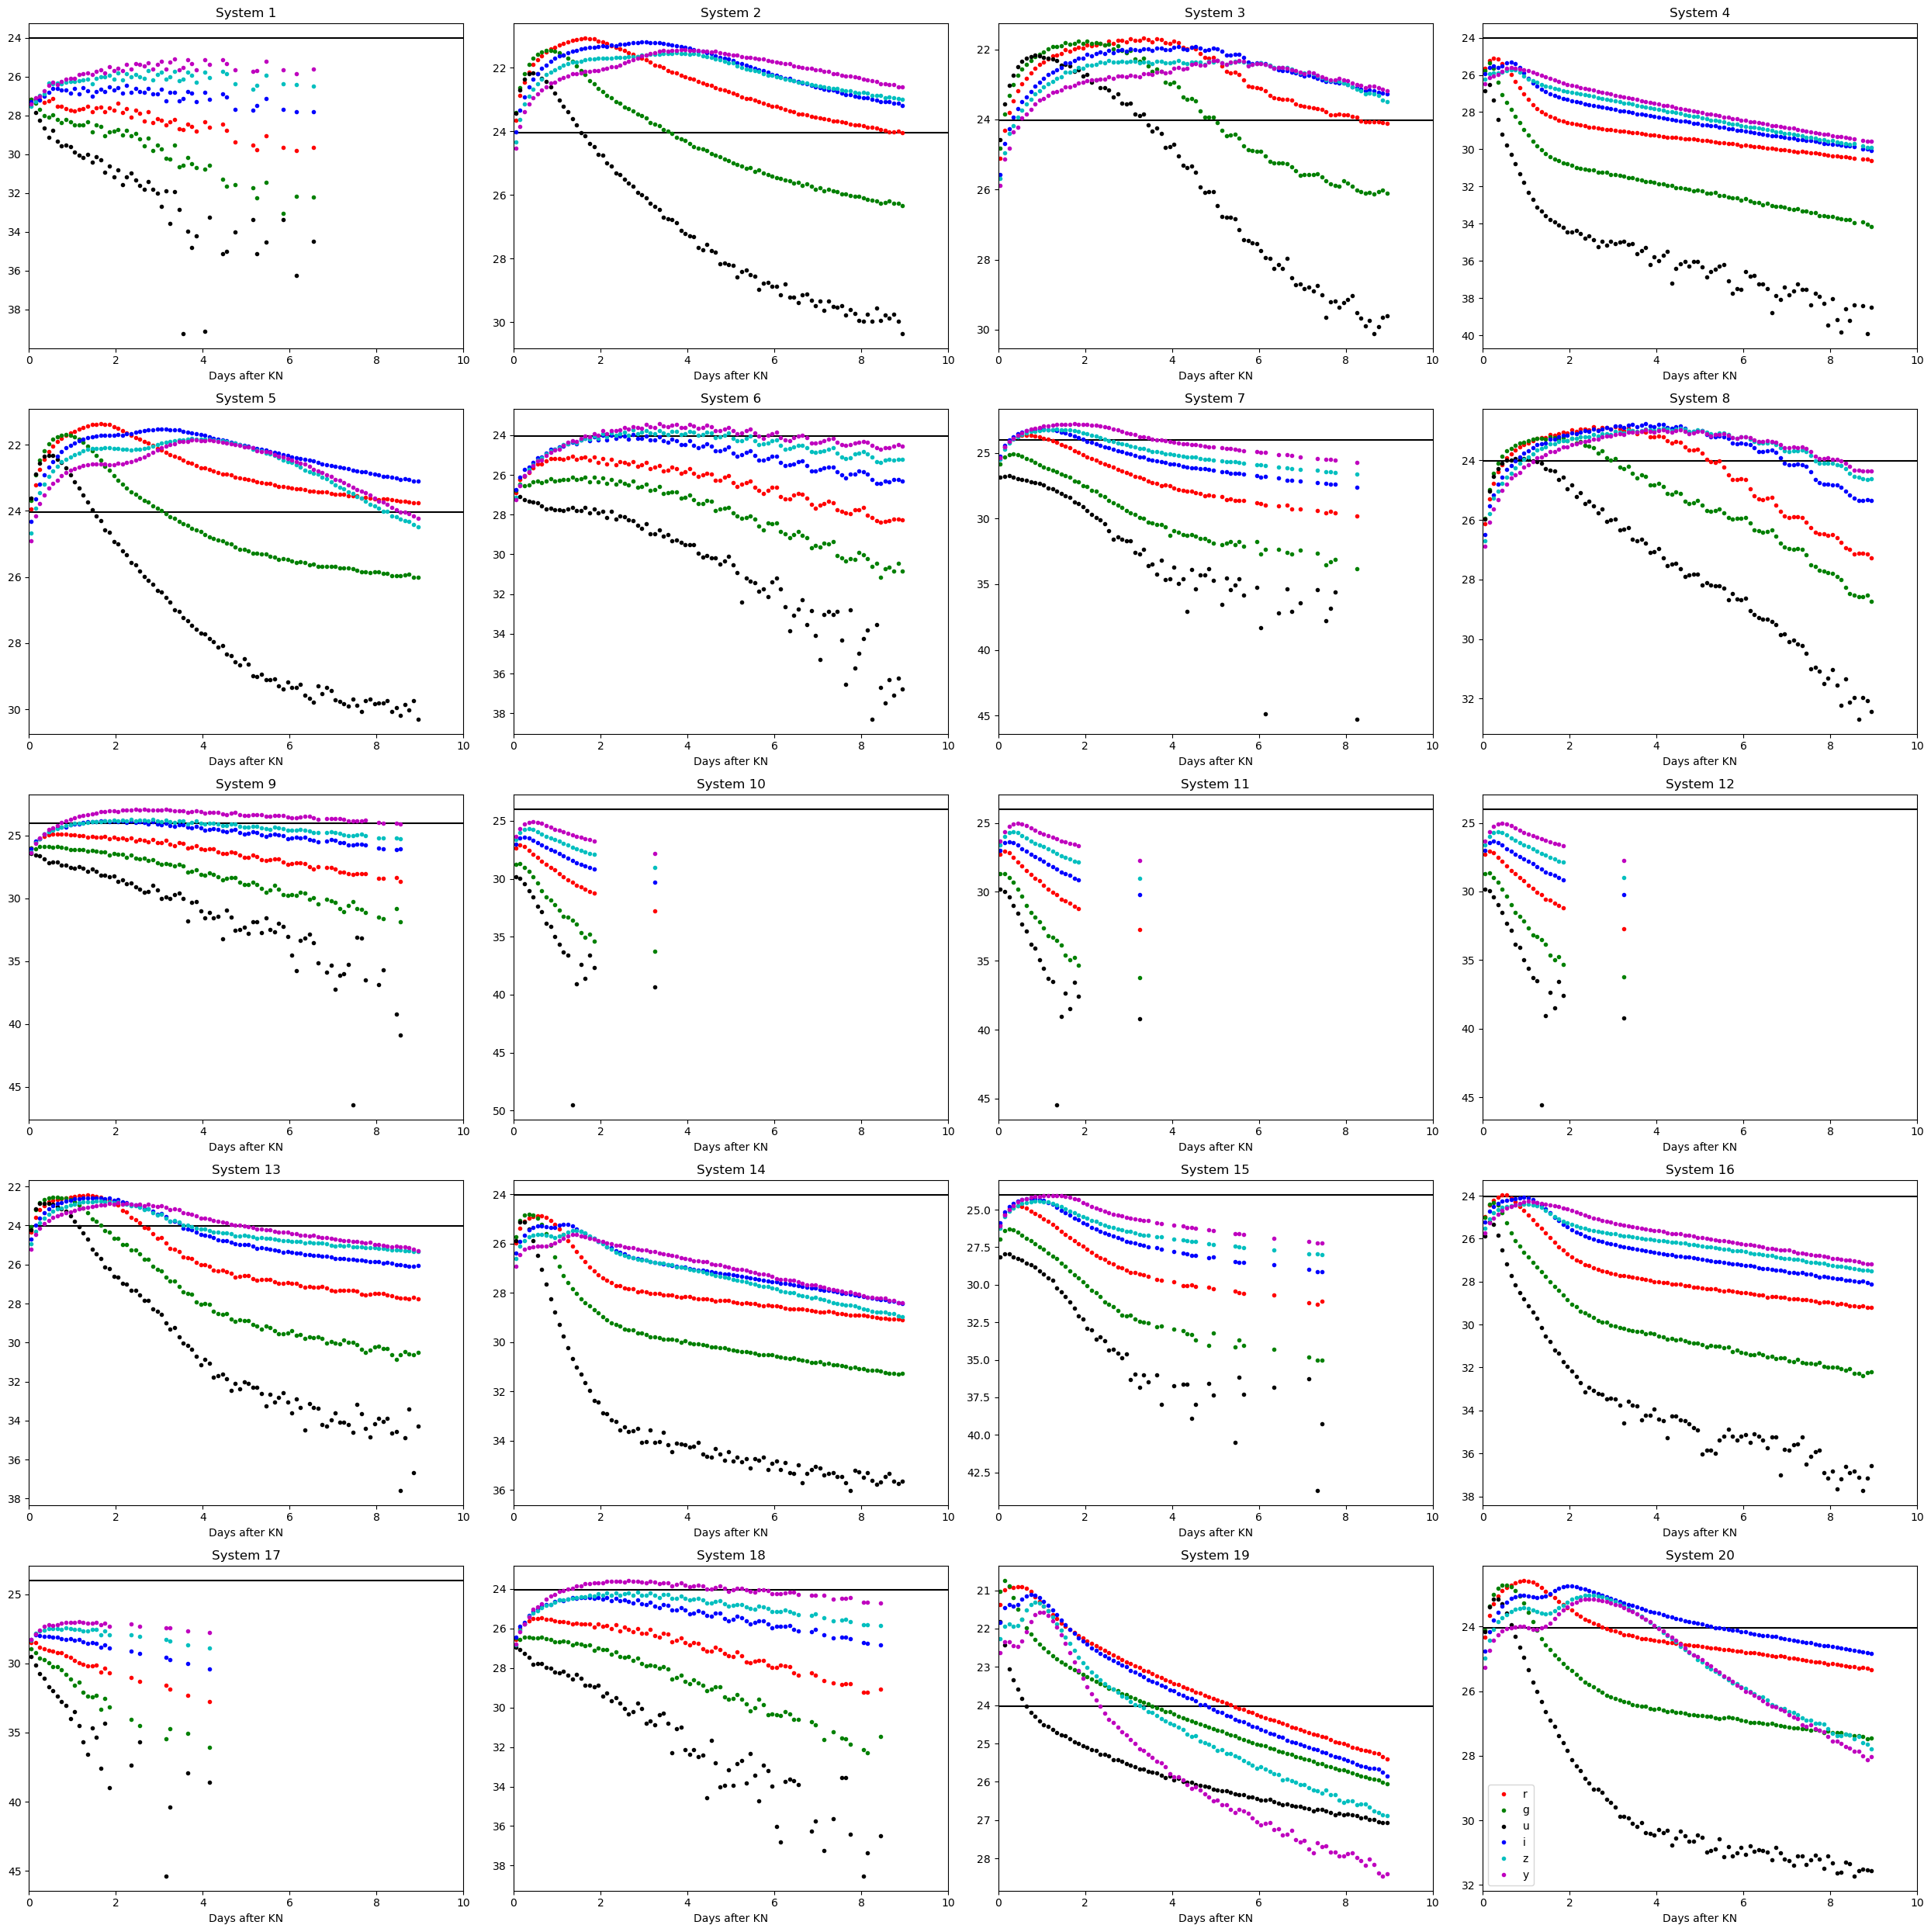

In [52]:
fig, ax = plt.subplots(5, 4, figsize=(25, 25), sharey=False, sharex=False)
x = 0
for i in range(5):
    for j in range(4):
        
        filename = home+'KDC/notebooks/output/light_curve_'+str(x)+'.txt'
        outfile = pd.read_csv(filename)
        fine = outfile[outfile['u']>-9999]
        r = fine['r']
        g = fine['g']
        ii = fine['i']
        u = fine['u']
        z = fine['z']
        y = fine['y']
        timer = fine['time']
        
        ax[i,j].plot([-10,20],[24.03,24.03],'.k-')  #r
        ax[i,j].set_xlim(0,10)
        ax[i,j].plot(timer, r, ".r", label = "r")
        ax[i,j].plot(timer, g, ".g", label = "g") 
        ax[i,j].plot(timer, u, ".k", label = "u") 
        ax[i,j].plot(timer, ii, ".b", label = "i")
        ax[i,j].plot(timer, z, ".c", label = "z")
        ax[i,j].plot(timer, y, ".m", label = "y")        
        plt.legend()
        ax[i, j].xaxis.set_label_text('Days after KN')
        ax[i, j].invert_yaxis()
        ax[i, j].set_title('System '+str(x+1))
        x += 1
        
plt.savefig("lightcurve.pdf", format='pdf')
plt.tight_layout()
plt.show()
plt.close()